# Distribution Adjustment

This notebook shows `scipy.stats` capabilities in Distribution Adjustments of [Continuous Random Variables][1] (see [list][4]):

 - We generate random sample from a known distribution;
 - We adjust parameters using [Maximum Likelihood Estimation][2];
 - We check adjustments with [Kolgomorov-Smirnov Test][3].

[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html
[2]: https://en.wikipedia.org/wiki/Maximum_likelihood_estimation
[3]: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
[4]: https://docs.scipy.org/doc/scipy/reference/stats.html


## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')
import pathlib

In [2]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 1.25*np.array(mpl.rcParams['figure.figsize'])
import pandas as pd

In [3]:
from scipy import stats
from scipy import signal
#import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

## Theoritical Distribution

First we create a plausible [Log-Normal][1] distribution (see [implementation][2]) in Air Quality field.

[1]: https://en.wikipedia.org/wiki/Log-normal_distribution
[2]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm

In [4]:
ln = stats.lognorm(s=np.log(2.8), scale=3.5)
ln

Note that all distributions in `scipy.stats` are normalized by definition. An extra transformation can be applied using *location* $x_0$ and *scale* $k$ parameters, such as:

$$z = \frac{x - x_0}{k}$$

We plot the Distribution PDF and CDF over linear and logarithmic axes:

In [5]:
x = np.logspace(-2, 2, 1000, base=10)
bins = np.logspace(-2, 2, 40, base=10)

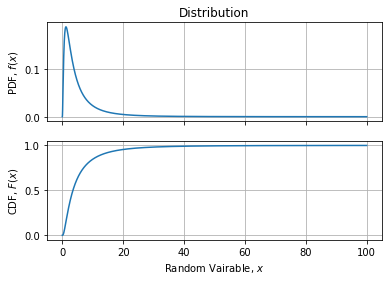

In [6]:
fig, axe = plt.subplots(2, 1, sharex=True)
axe[0].plot(x, ln.pdf(x))
axe[1].plot(x, ln.cdf(x))
axe[0].set_title("Distribution")
axe[1].set_xlabel("Random Vairable, $x$")
axe[0].set_ylabel("PDF, $f(x)$")
axe[1].set_ylabel("CDF, $F(x)$")
axe[0].grid(which='both')
axe[1].grid(which='both')

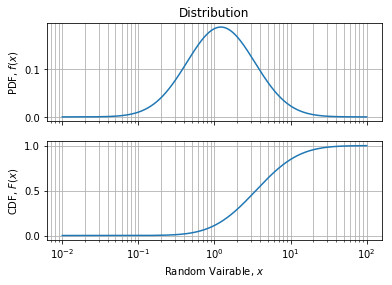

In [7]:
fig, axe = plt.subplots(2, 1, sharex=True)
axe[0].semilogx(x, ln.pdf(x))
axe[1].semilogx(x, ln.cdf(x))
axe[0].set_title("Distribution")
axe[1].set_xlabel("Random Vairable, $x$")
axe[0].set_ylabel("PDF, $f(x)$")
axe[1].set_ylabel("CDF, $F(x)$")
axe[0].grid(which='both')
axe[1].grid(which='both')

## Pseudo Random Sampling

We fix the seed for reproductible execution of the notebook, comment the following line for more randomness:

In [8]:
pgrn = np.random.seed(73)

We sample from the above defined definition:

In [9]:
N = 10000
data = ln.rvs(N, random_state=pgrn)
data[:5]

array([  6.33861878,  31.40584322,  43.17495236,   4.59004317,   0.75000763])

As a first glance, we plot the histogram and its KDE:

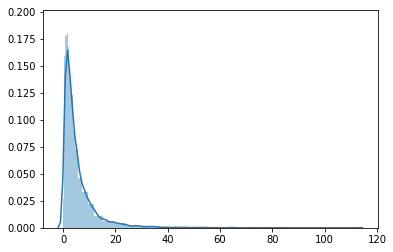

In [10]:
axe = sns.distplot(data, bins=bins)

## Maximum Likelihood Estimation

Now, we will estimate distribution parameters using [`fit`][1] method of the `scipy.stats.rv_continuous` class which implements a [Maximum Likelihood Estimation][2] methodology.

[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html
[2]: https://docs.scipy.org/doc/scipy/reference/tutorial/stats/continuous.html#fitting-data

First we fit without restriction on *location* and scale *parameters*:

In [11]:
z = (s, x1, k1) = stats.lognorm.fit(data)
z

(1.1205351147063887, -0.0033137964684586858, 4.0575292051288923)

We see than *location* is slightly negative.

We generate a new Distribution with estimated parameters and render a distribution figure:

In [12]:
lnexp1 = stats.lognorm(s, loc=x1, scale=k1)

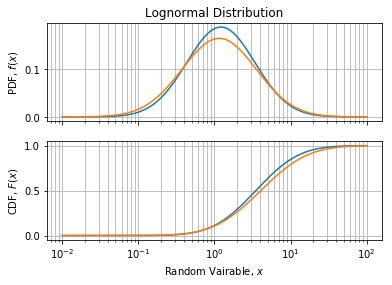

In [13]:
fig, axe = plt.subplots(2, 1, sharex=True)
axe[0].semilogx(x, ln.pdf(x))
axe[0].semilogx(x, lnexp1.pdf(x))
axe[1].semilogx(x, ln.cdf(x))
axe[1].semilogx(x, lnexp1.cdf(x))
axe[0].set_title("Lognormal Distribution")
axe[1].set_xlabel("Random Vairable, $x$")
axe[0].set_ylabel("PDF, $f(x)$")
axe[1].set_ylabel("CDF, $F(x)$")
axe[0].grid(which='both')
axe[1].grid(which='both')

Qualitatively, it poorly fits.

We perform again the adjustment forcing location parameters to be `0`.

In [14]:
z = (s, _, k2) = stats.lognorm.fit(data, floc=0)
z

(1.022981852473992, 0, 3.4547208026117389)

In [15]:
np.log(2.8)

1.0296194171811581

Anyway, shape parameter $s$ and scale $k$ are closer to the original distribution, distributions fit better:

In [16]:
lnexp2 = stats.lognorm(s, scale=k2)

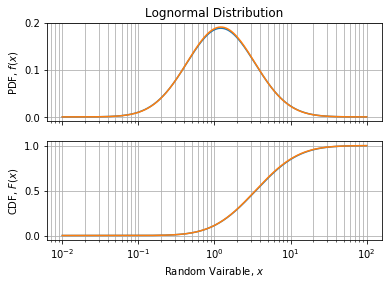

In [17]:
fig, axe = plt.subplots(2, 1, sharex=True)
axe[0].semilogx(x, ln.pdf(x))
axe[0].semilogx(x, lnexp2.pdf(x))
axe[1].semilogx(x, ln.cdf(x))
axe[1].semilogx(x, lnexp2.cdf(x))
axe[0].set_title("Lognormal Distribution")
axe[1].set_xlabel("Random Vairable, $x$")
axe[0].set_ylabel("PDF, $f(x)$")
axe[1].set_ylabel("CDF, $F(x)$")
axe[0].grid(which='both')
axe[1].grid(which='both')
plt.show(fig)

### Adjustment Comparison

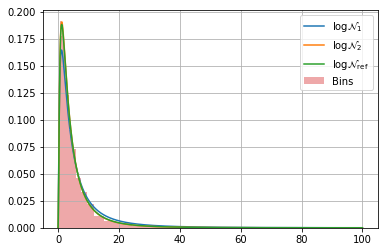

In [18]:
fig, axe = plt.subplots()
axe.plot(x, lnexp1.pdf(x), label='$\log\mathcal{N}_1$')
axe.plot(x, lnexp2.pdf(x), label='$\log\mathcal{N}_2$')
axe.plot(x, ln.pdf(x), label=r'$\log\mathcal{N}_\mathrm{ref}$')
sns.distplot(data, bins=bins, norm_hist=True, kde=False, ax=axe, label='Bins')
axe.legend()
axe.grid()

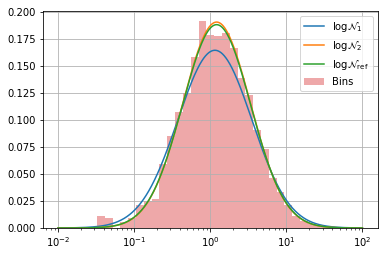

In [19]:
fig, axe = plt.subplots()
axe.semilogx(x, lnexp1.pdf(x), label=r'$\log\mathcal{N}_1$')
axe.semilogx(x, lnexp2.pdf(x), label=r'$\log\mathcal{N}_2$')
axe.semilogx(x, ln.pdf(x), label=r'$\log\mathcal{N}_\mathrm{ref}$')
sns.distplot(data, bins=bins, norm_hist=True, kde=False, ax=axe, label='Bins')
axe.legend()
axe.grid()

In [20]:
aerr1 = np.abs(lnexp1.cdf(x) - ln.cdf(x))
rerr1 = aerr1/ln.cdf(x)

In [21]:
aerr2 = np.abs(lnexp2.cdf(x) - ln.cdf(x))
rerr2 = aerr2/ln.cdf(x)

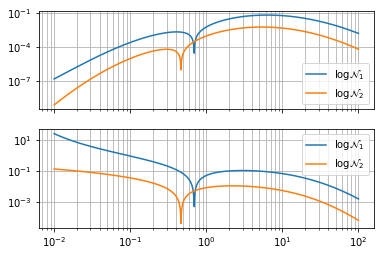

In [22]:
fig, axe = plt.subplots(2, 1, sharex=True)
axe[0].loglog(x, aerr1, label=r'$\log\mathcal{N}_1$')
axe[0].loglog(x, aerr2, label=r'$\log\mathcal{N}_2$')
axe[1].loglog(x, rerr1, label=r'$\log\mathcal{N}_1$')
axe[1].loglog(x, rerr2, label=r'$\log\mathcal{N}_2$')
for i in range(2):
    axe[i].grid(which='both')
    axe[i].legend()

## QQ-Plots

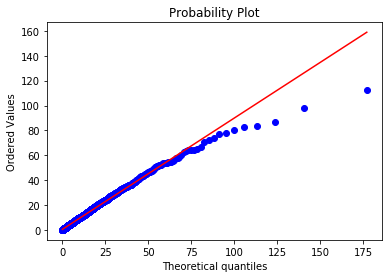

In [23]:
fig, axe = plt.subplots()
_ = stats.probplot(data, plot=axe, dist=ln)

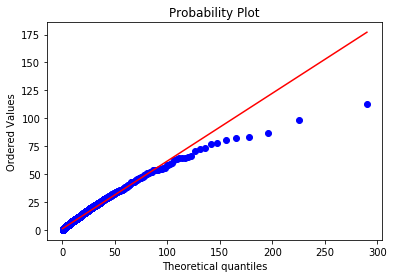

In [24]:
fig, axe = plt.subplots()
_ = stats.probplot(data, plot=axe, dist=lnexp1)

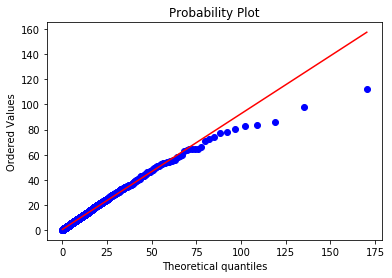

In [25]:
fig, axe = plt.subplots()
_ = stats.probplot(data, plot=axe, dist=lnexp2)

## Kolgomorov-Smirnov Test

We will use here an objective criterion to assess if our sample could reasonabiliy beeing drawn from our fitted distributions. We chose the [Kolgomorov-Smirnov Test][1] implemented in method [`scipy.stats.kstest`][2].

The test return the value of the statistics $D$ and its [$p$-value][3] (see this [question][4] for some insight) or this quote from Wikipedia:

> In statistical hypothesis testing, the p-value or probability value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results.

[1]: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
[2]: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html
[3]: https://en.wikipedia.org/wiki/P-value
[4]: https://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python

In [26]:
stats.kstest(data, lnexp1.cdf)

KstestResult(statistic=0.069751826497034375, pvalue=1.1000714066811569e-42)

In [27]:
stats.kstest(data, lnexp2.cdf)

KstestResult(statistic=0.0073011801079173599, pvalue=0.66068743083562542)

What we can infer from those tests:

 - First adjustment (negative location) has a extremly low $p$-value, it is fairly unprobable that the $D$ statistics could be of this magnitude or greater, then we reject the null hypothesis, we do not believe the sample can be drawn from this distribution;
 - Second adjustment (null location) has high $p$-value above $5\%$, we do not reject the null hypothesis. It is plausible to believe than our sample is drawn from this distribution, but this is not a proof that our sample actually comes from this distribution.

## Real Datasets

In [28]:
df = pd.read_pickle('../../data/RTU_30T_2012_2016.pickle')
sample = df.loc[:,pd.IndexSlice[['PM-2.5', 'BC'],:,:]]
sample.head()

measurandkey            BC                             PM-2.5                \
sitekey             41N043 41R001 41R002 41R012 41WOL1 41B011 41MEU1 41N043   
channelid              98     117    162    172    193    67     93     112   
timevalue                                                                     
2012-01-01 00:00:00    NaN  0.870  1.925    NaN  0.630   6.95   8.75  19.75   
2012-01-01 01:00:00    NaN  0.555  1.710    NaN  0.535   5.65   4.15  14.50   
2012-01-01 02:00:00    NaN  0.575  1.440    NaN  0.415   4.15   4.70  12.10   
2012-01-01 03:00:00    NaN  0.425  0.930    NaN  0.320   5.00   5.55  11.15   
2012-01-01 04:00:00    NaN  0.415  0.810    NaN  0.295   3.45   5.75  12.35   

measurandkey                       
sitekey             41R001 41R012  
channelid              131    185  
timevalue                          
2012-01-01 00:00:00  17.15  11.65  
2012-01-01 01:00:00  11.85   8.95  
2012-01-01 02:00:00  11.75   8.45  
2012-01-01 03:00:00  12.00   7.35  
2012-01-01 04:00:00  12.10   9.50

In [48]:
def fitDistribution(x, nrem=0, key='', dist=stats.lognorm, dist_kw={}, hist_kw={}, axelog=True):
    hist_kws = {'bins': 'log', 'normed': True}
    hist_kws.update(hist_kw)
    # Casting:
    if isinstance(x, (pd.DataFrame, pd.Series)):
        x = np.squeeze(x.values)
    assert len(x.shape) == 1
    # Drop NaN and sort:
    x = np.sort(x[~np.isnan(x)])
    # Remove Outliers:
    if (nrem>0):
        x = x[:-nrem]
    # Fit to distribution:
    beta = dist.fit(x, **dist_kw)
    # Create Distribution:
    fdist = dist(*beta)
    # Kolgomorov-Smirnov Test:
    ks = stats.kstest(x, fdist.cdf)
    # Bins:
    n = x.size
    extent = x[-1]-x[0]
    nbins = int(np.round(1 + 3.4*np.log10(n)))
    xax = None
    if isinstance(hist_kws['bins'], str):
        if hist_kws['bins'] == 'lin':
            hist_kws['bins'] = np.linspace(x[0], x[-1], nbins+1)
        else:
            hist_kws['bins'] = np.logspace(np.log10(x[0]), np.log10(x[-1]), nbins+1)
            xax = np.logspace(np.log10(x[0]), np.log10(x[-1]), 250)
    if xax is None:
        xax = np.linspace(x[0], x[-1], 250)
    # ECDF:
    ecdf = ECDF(x)
    # Plot:
    fig, axe0 = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2, 2]})
    hist = axe0[0].hist(x, **hist_kws, label='Experimental Data')
    axe0[0].plot(xax, fdist.pdf(xax), label=r'MLE Fit: $\beta$={} KS(D={:.3f}, p={:.3e})'.format(tuple([float('{:.3f}'.format(b)) for b in beta]), ks.statistic, ks.pvalue))
    axe0[1].step(ecdf.x, ecdf.y, where='post', label='ECDF')
    axe0[1].plot(xax, fdist.cdf(xax), label='Fitted CDF')
    axe0[2].plot(x, ecdf.y[1:] - fdist.cdf(x), label='$\Delta F(x)$')
    axe0[0].set_title('Distribution Fit ({}): {}'.format(dist.name, key))
    axe0[2].set_xlabel('Random Variable, $x$')
    axe0[0].set_ylabel('$f(x)$')
    axe0[1].set_ylabel('$F(x)$')
    axe0[2].set_ylabel('$D$')
    if axelog:
        axe0[0].set_xscale("log", nonposx='clip')
    for i in range(3):
        axe0[i].legend(bbox_to_anchor=(1,1), loc='upper left')
        axe0[i].grid(which='both')
    # Assemble Result:
    return {
        'data': x
       ,'n': n
       ,'nbins': nbins
       ,'extent': extent
       ,'ecdf': ecdf
       ,'beta': beta
       ,'fit': fdist
       ,'KS': ks
       ,'distplot': axe0
    }

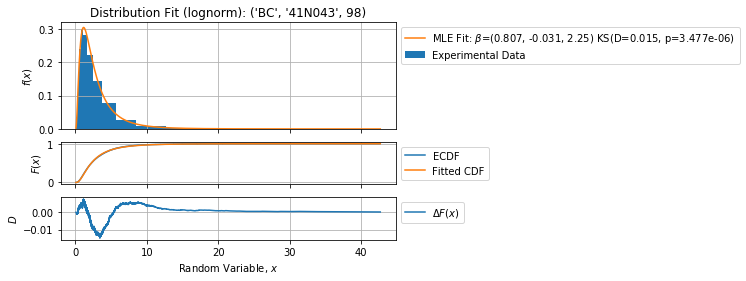

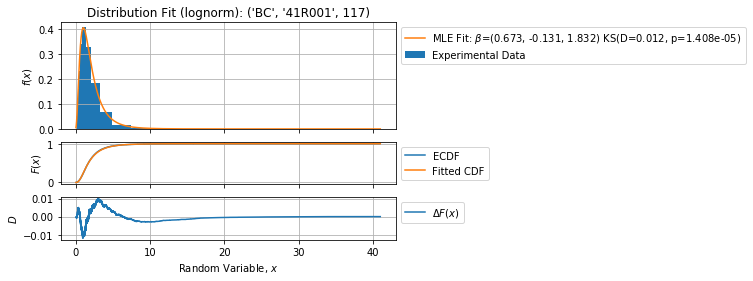

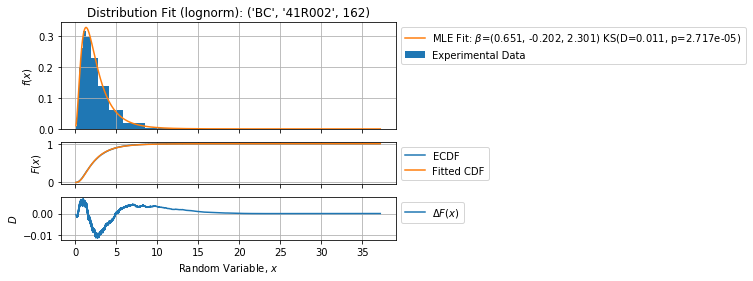

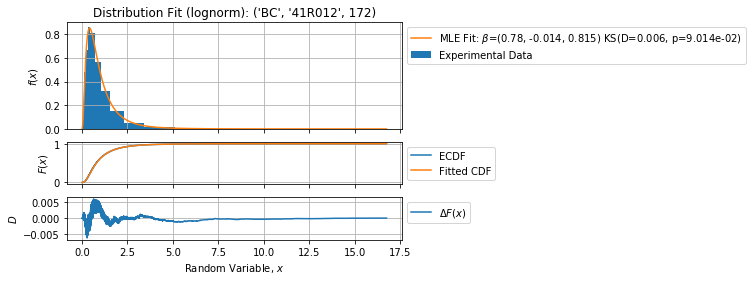

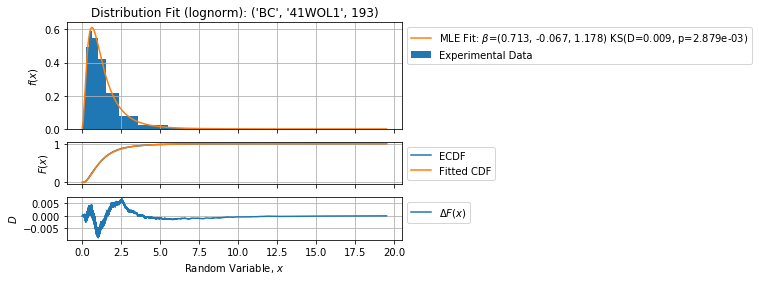

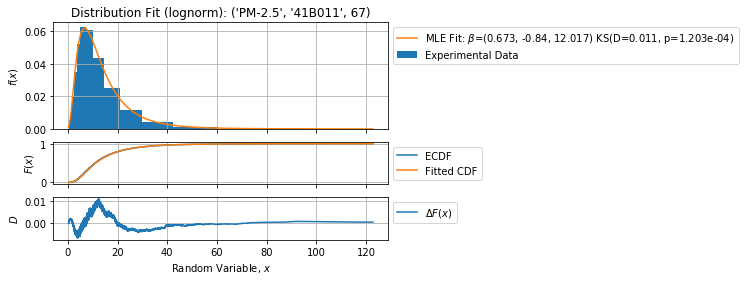

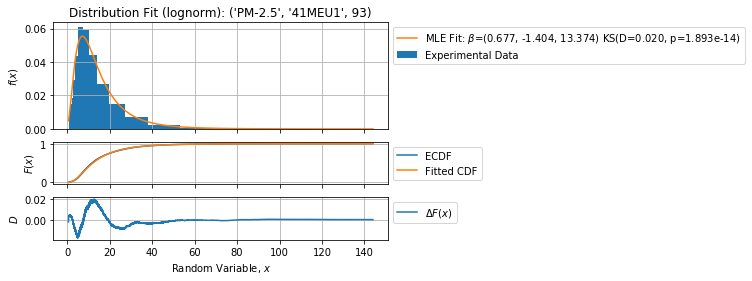

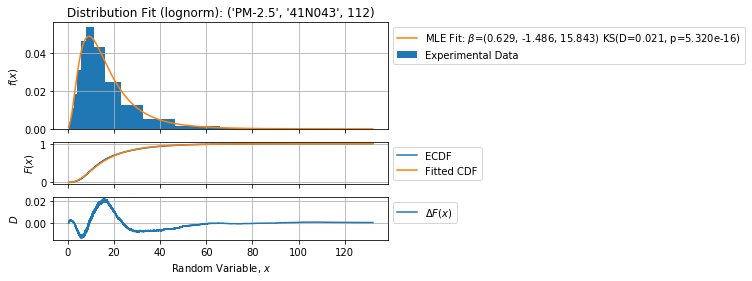

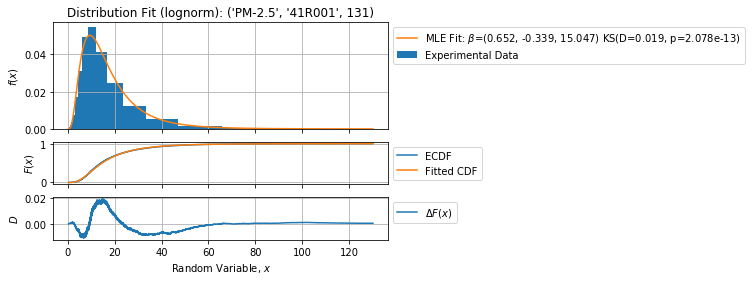

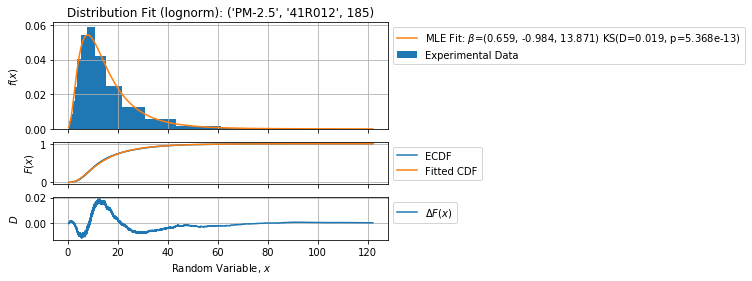

In [49]:
for k in sample:
    fitDistribution(sample[k], key=k, axelog=False)

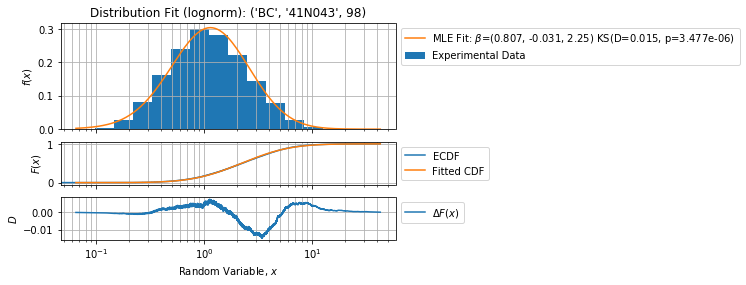

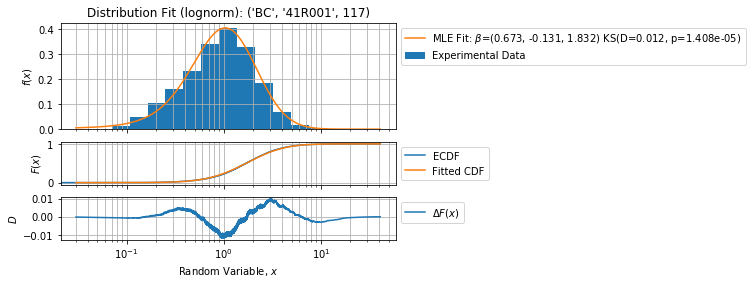

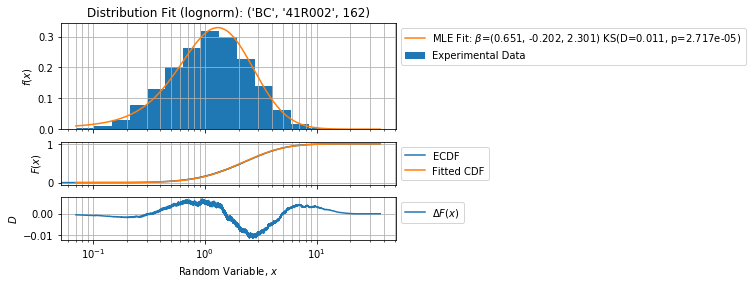

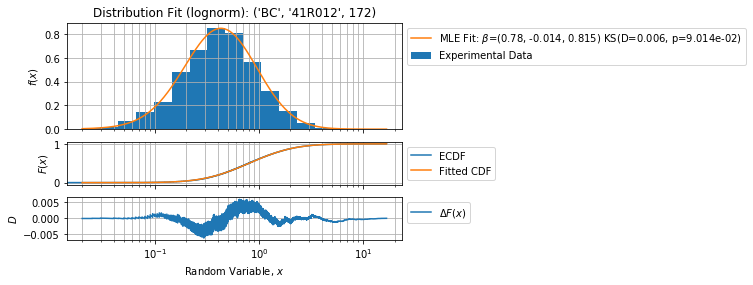

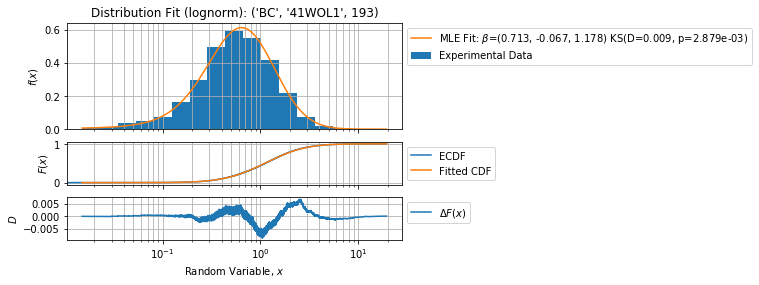

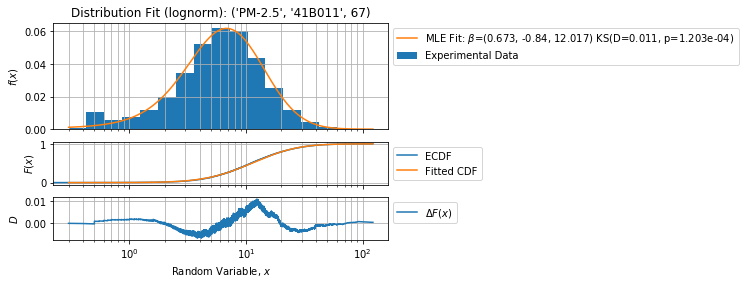

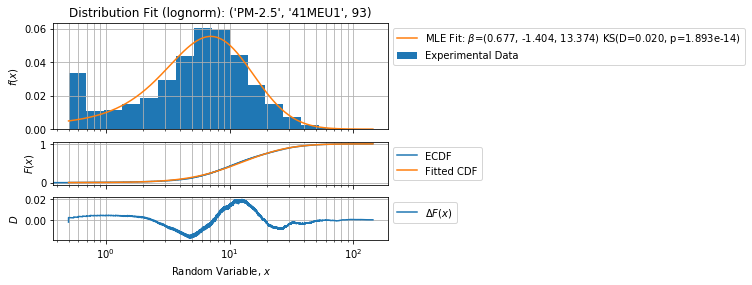

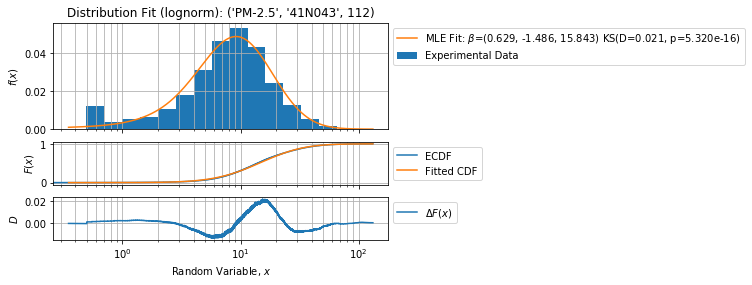

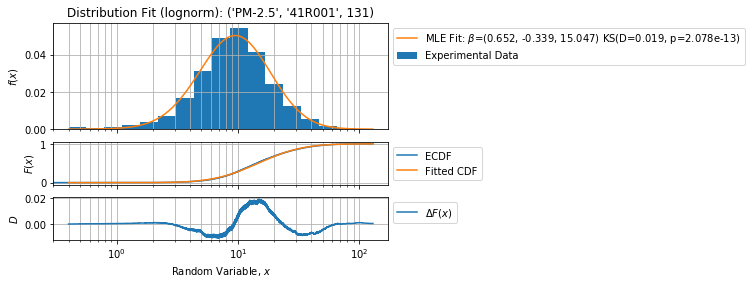

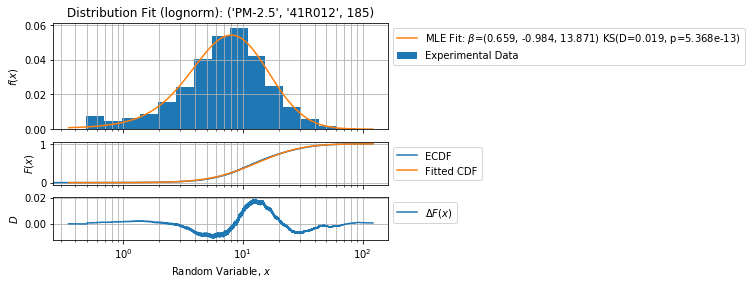

In [50]:
for k in sample:
    fitDistribution(sample[k], key=k)